In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, mpld3
import pandas as pd, numpy as np
sn.set_context('notebook')

## 1. Read data and join

In [2]:
# Read basic datasets

# Hydro indicators
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\hydro_indic.xlsx'
hi_df = pd.read_excel(in_xls, sheetname='hydro_indic', index_col=0)

# Site props
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\site_props.xlsx'
site_df = pd.read_excel(in_xls, sheetname='site_props', index_col=0)

# MZB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\mzb_chem_ecol.xlsx'
mzb_df = pd.read_excel(in_xls, sheetname='mzb_data', index_col=0)

# PB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\pb_chem_ecol.xlsx'
pb_df = pd.read_excel(in_xls, sheetname='pb_data', index_col=0)

In [11]:
# Get relevant HI
pb1_hi = hi_df.query('(eco_dataset=="pb") & (time_per==1)')

# Join
pb1_df = pd.concat([site_df, pb1_hi, pb_df], axis=1)

# Drop 4 PB sites not relevant to MZB
pb1_df.dropna(how='any', inplace=True)

# Remove unwanted cols
pb1_df.drop(['name', 'eco_dataset', 'time_per'], axis=1, 
            inplace=True)

len(pb1_df)

65

## 2. Regression code

In [5]:
def mlr(df, exp_vars, resp_var, 
        method='ols', 
        fit_intercept=True,
        kcv=3,
        normalize=False):
    """ Performs various types of multiple linear regression.
    
    Args:
        df:            Data frame with features/responses as columns 
                       and samples as rows.
        exp_vars:      List of string specifying explanatory variables.
        resp_var:      String specifying the response variable.
        method:        'ols', 'lasso', 'ridge', 'el-net'.
        fit_intercept: Whether to fit an intercept. Default is True.
        kcv:           Number of "folds" for k-fold cross validation.
                       Default is 3.
        normalize:     Whether to normalise X before regression.
                       Default is False.
    Returns:
        A data frame of parameter estimates with (rather dodgy?)
        2-sigma error bounds and 95% significance
    """
    from sklearn import cross_validation
    from sklearn.linear_model import LinearRegression, RidgeCV
    from sklearn.linear_model import LassoCV, ElasticNetCV
    from sklearn.metrics import r2_score
    from sklearn.utils import resample 
    
    # Separate data
    X = df[exp_vars]
    y = df[resp_var]
    
    # Setup model
    if method == 'ols':
        model = LinearRegression(fit_intercept=fit_intercept, normalize=normalize)
    elif method == 'lasso':
        model = LassoCV(fit_intercept=fit_intercept, normalize=normalize, max_iter=10000)
    elif method == 'ridge':
        model = RidgeCV(fit_intercept=fit_intercept, normalize=normalize, 
                        alphas=np.logspace(-10, 10, 21))
    elif method == 'el-net':
        model = ElasticNetCV(fit_intercept=fit_intercept, normalize=normalize)
    else:
        raise ValueError('"method" parameter must be in ["ols", "lasso", "ridge", "el-net"]')
    
    # k-fold cross validation
    cv_scores = cross_validation.cross_val_score(model, X, y, cv=kcv, scoring='r2')
    print 'Mean r2 from %s-fold CV: %.3f\n' % (kcv, cv_scores.mean())
    
    # Train model on full dataset
    model.fit(X, y)
    
    # Get y-hat
    y_pred = model.predict(X)
    
    # r2 based on calibration data
    r2 = r2_score(y, y_pred)
    print 'r2 (based on the calibration data i.e. meaningless!):', r2
    print ''
    
    # Summary of model
    print model
    print ''
    
    if method == 'lasso':
        print 'Lasso alpha:', model.alpha_
        print ''
    elif method == 'ridge':
        print 'Ridge alpha:', model.alpha_
        print ''
    elif method == 'el-net':
        print 'Elastic net alpha:', model.alpha_   
        print 'Elastic net L1 ratio:', model.l1_ratio_ 
        print ''
    else: # OLS
        pass
    
    # Plot
    fig = plt.figure(figsize=(15,15))
    
    # Paired points for each site
    ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)
    ax1.plot(range(0, len(X.index)), y, 'ro', label='Observed')
    ax1.plot(range(0, len(X.index)), y_pred, 'b^', label='Modelled')
    
    ax1.set_xticks(range(0, len(X.index)))
    ax1.set_xticklabels(X.index, rotation=90, fontsize=12)
    ax1.set_xlim(0, len(X.index)-1)
    
    ax1.set_xlabel('Site code', fontsize=16)
    ax1.set_ylabel(resp_var)
    ax1.set_title('Points paired for each location', fontsize=20)
    ax1.legend(loc='best', fontsize=16)
    
    # Modelled versus observed
    ax2 = plt.subplot2grid((2,2), (1,0), colspan=1)
    ax2.plot(y, y_pred, 'ro')
    ax2.set_xlabel('Observed', fontsize=16)
    ax2.set_ylabel('Modelled', fontsize=16)
    ax2.set_title('Modelled versus observed', fontsize=20)
    
    # Hist of residuals
    ax3 = plt.subplot2grid((2,2), (1,1), colspan=1)
    sn.distplot(y - y_pred, kde=True, ax=ax3)
    ax3.set_title('Histogram of residuals', fontsize=20)
    
    plt.tight_layout()
    
    # Get param estimates
    params = pd.Series(model.coef_, index=X.columns)

    # Estimate confidence using bootstrap
    # i.e. what is the std. dev. of the estimates for each parameter
    # based on 1000 resamplings
    err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 
                 axis=0)

    # Build df
    res = pd.DataFrame({'effect':params,
                        'error':2*err})

    # Rough indicator of significance: are the estimated values more than
    # 2 std. devs. from 0 (~95% CI?). NB: this assumnes the "marginal posterior"  
    # is normal, which I haven't tested for and which quite possibly isn't true
    # - use with care! 
    res['signif'] = np.abs(res['effect']) > res['error']
    
    return res

## 3. Norway only
### 3.1. OLS on chem only

Number of sites included: 40
Mean r2 from 3-fold CV: -1.222

r2 (based on the calibration data i.e. meaningless!): 0.359552726325

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)



,effect,error,signif
tn,38.363661,36.764176,True
tp,-0.045857,0.426959,False
ph,6.068479,4.563836,True
cond,-0.193343,0.154015,True
toc,-0.530130,1.534238,False


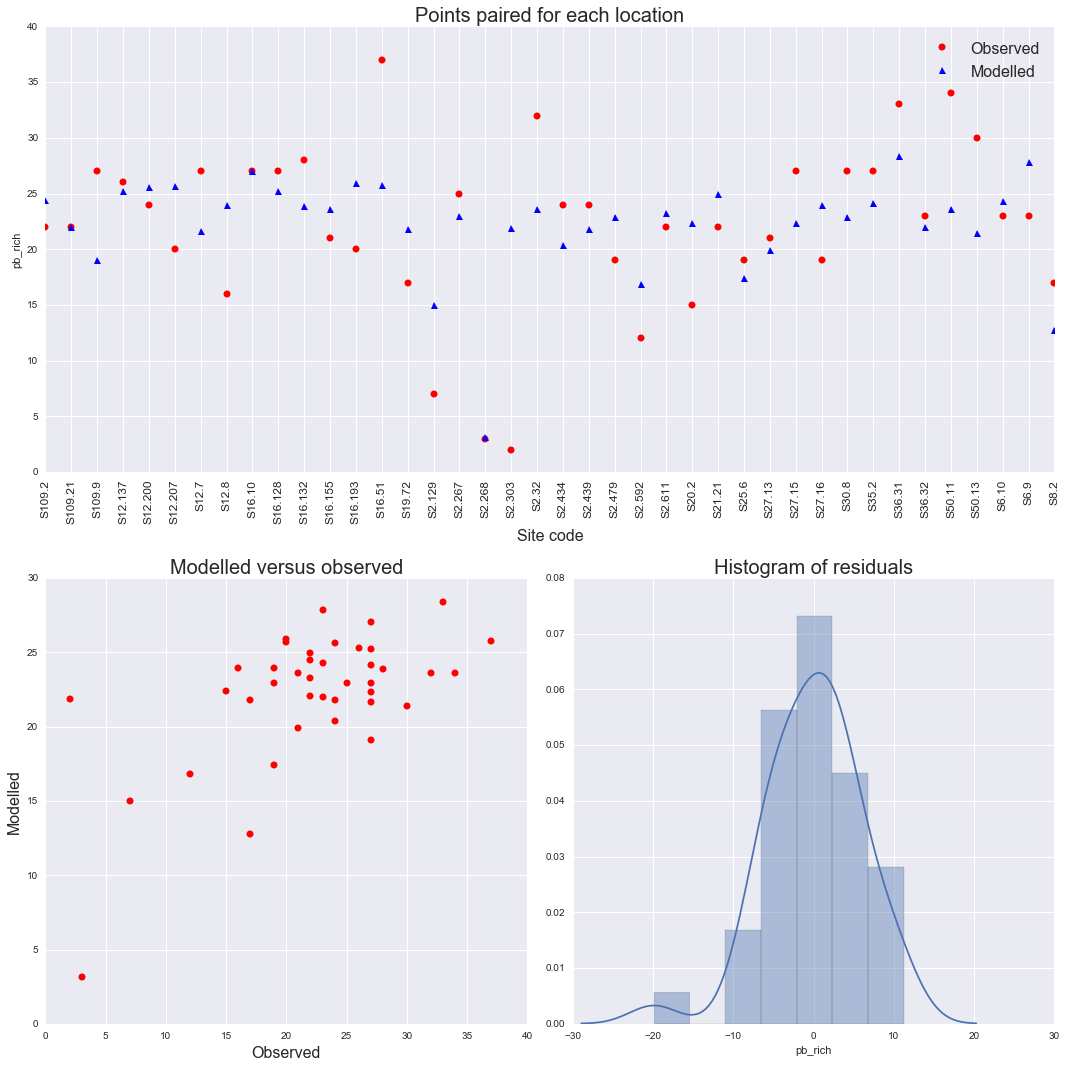

In [17]:
df = pb1_df.copy()

# Lists of explan and resp vars
exp_vars = ['tn', 'tp', 'ph', 'cond', 'toc']
resp_var = 'pb_rich'

# Filter by country
df = df.query('country == "N"')

print 'Number of sites included:', len(df)

# OLS
res = mlr(df, exp_vars, resp_var, 
          method='ols', fit_intercept=True, 
          kcv=3, normalize=False)
res

### 3.2. Elastic net on all vars

Mean r2 from 3-fold CV: -0.783

r2 (based on the calibration data i.e. meaningless!): 0.179674123502

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

Elastic net alpha: 195.69170602
Elastic net L1 ratio: 0.5



,effect,error,signif
lon,-0.000000,0.072102,False
lat,-0.000000,0.138706,False
mean,0.000000,0.000000,False
m01,0.000000,0.053663,False
m02,0.000000,0.055632,False
m03,0.000000,0.021884,False
m04,-0.000000,0.114368,False
m05,0.000000,0.204304,False
m06,-0.000000,0.161121,False
m07,-0.000000,0.094285,False


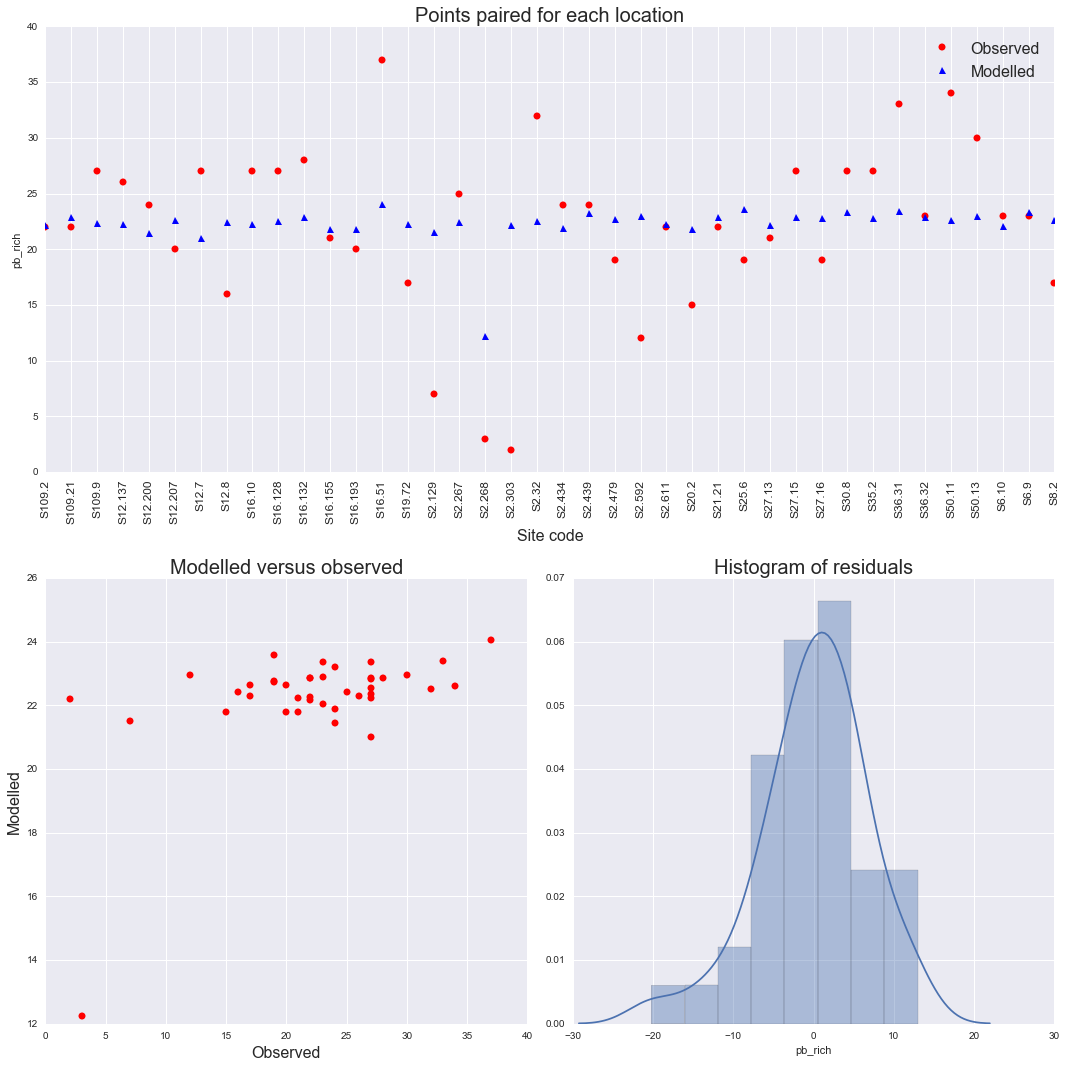

In [18]:
# Lists of explan and resp vars
exp_vars = ['lon', 'lat', 'mean', 'm01', 'm02', 'm03', 'm04', 'm05', 'm06',
            'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'min', 'p05', 'p25',
            'p50', 'p75', 'p95', 'max', 'range', 'iqr', 'range90', 'cv',
            'days_to_max', 'days_to_min', 'days_to_p05', 'days_to_p95',
            'ma_07_max', 'ma_07_min', 'ma_30_max', 'ma_30_min', 'ma_90_max',
            'ma_90_min', 'revs_per_yr', 'tn', 'tp', 'ph', 'cond', 'toc']

resp_var = 'pb_rich'

# OLS regression
res = mlr(df, exp_vars, resp_var, 
          method='el-net', fit_intercept=True, 
          kcv=3, normalize=False)
res

## 4. Germany only

### 4.1. OLS on chem only

Number of sites included: 25
Mean r2 from 3-fold CV: -0.193

r2 (based on the calibration data i.e. meaningless!): 0.241768035347

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)



,effect,error,signif
tn,0.214370,1.376429,False
tp,0.001456,0.025542,False
ph,-1.109952,4.918051,False
cond,-0.009373,0.017243,False
toc,-0.318599,1.295909,False


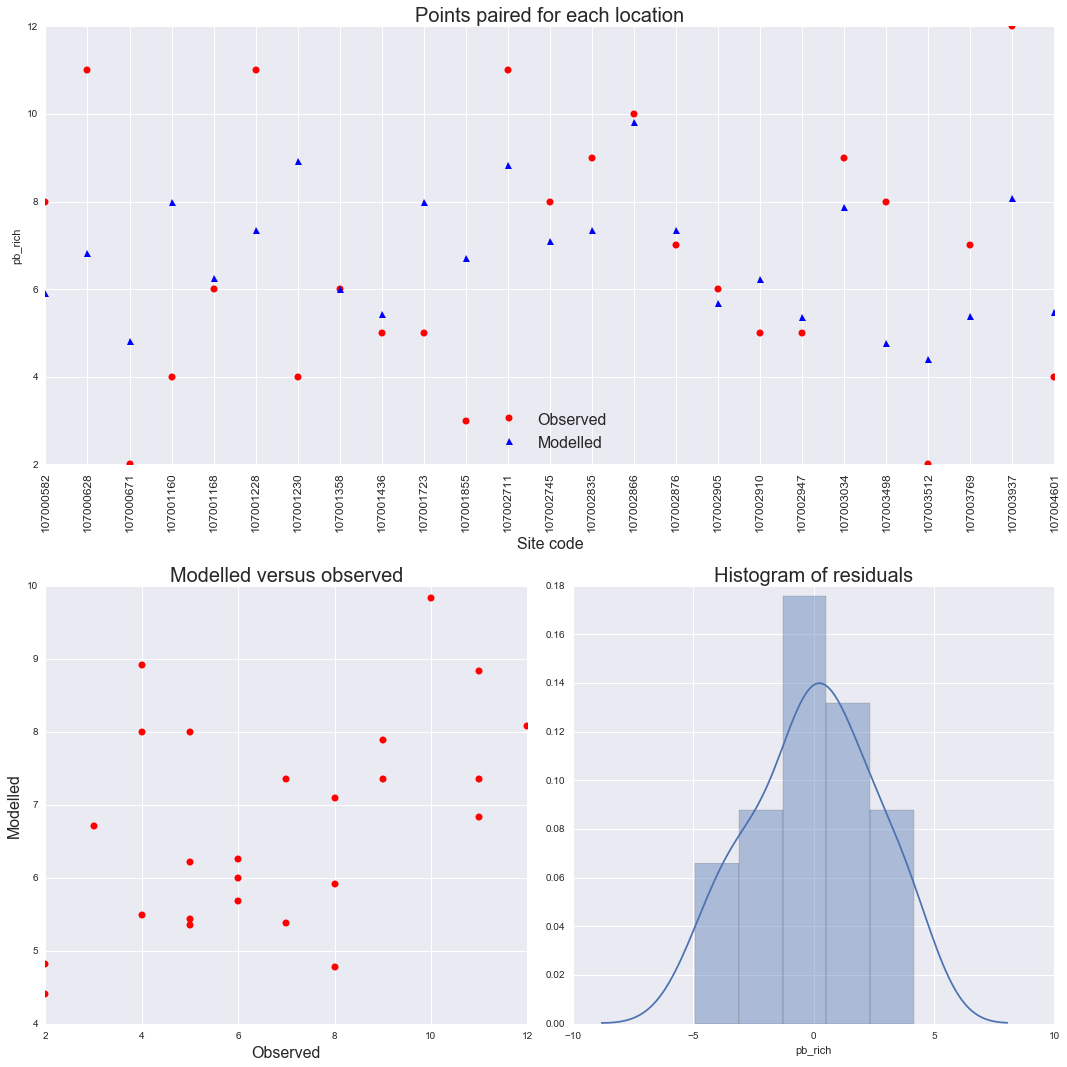

In [19]:
df = pb1_df.copy()

# Lists of explan and resp vars
exp_vars = ['tn', 'tp', 'ph', 'cond', 'toc']
resp_var = 'pb_rich'

# Filter by country
df = df.query('country == "D"')

print 'Number of sites included:', len(df)

# OLS
res = mlr(df, exp_vars, resp_var, 
          method='ols', fit_intercept=True, 
          kcv=3, normalize=False)
res

### 4.2. Elastic net on all vars

Mean r2 from 3-fold CV: -0.403

r2 (based on the calibration data i.e. meaningless!): 0.181566536743

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

Elastic net alpha: 132.5362814
Elastic net L1 ratio: 0.5



,effect,error,signif
lon,0.000000,0.009475,False
lat,0.000000,0.000000,False
mean,0.000000,0.000000,False
m01,0.000000,0.123266,False
m02,0.000000,0.051235,False
m03,0.000000,0.077537,False
m04,0.000000,0.021194,False
m05,-0.000000,0.059091,False
m06,0.000000,0.021842,False
m07,0.000000,0.012339,False


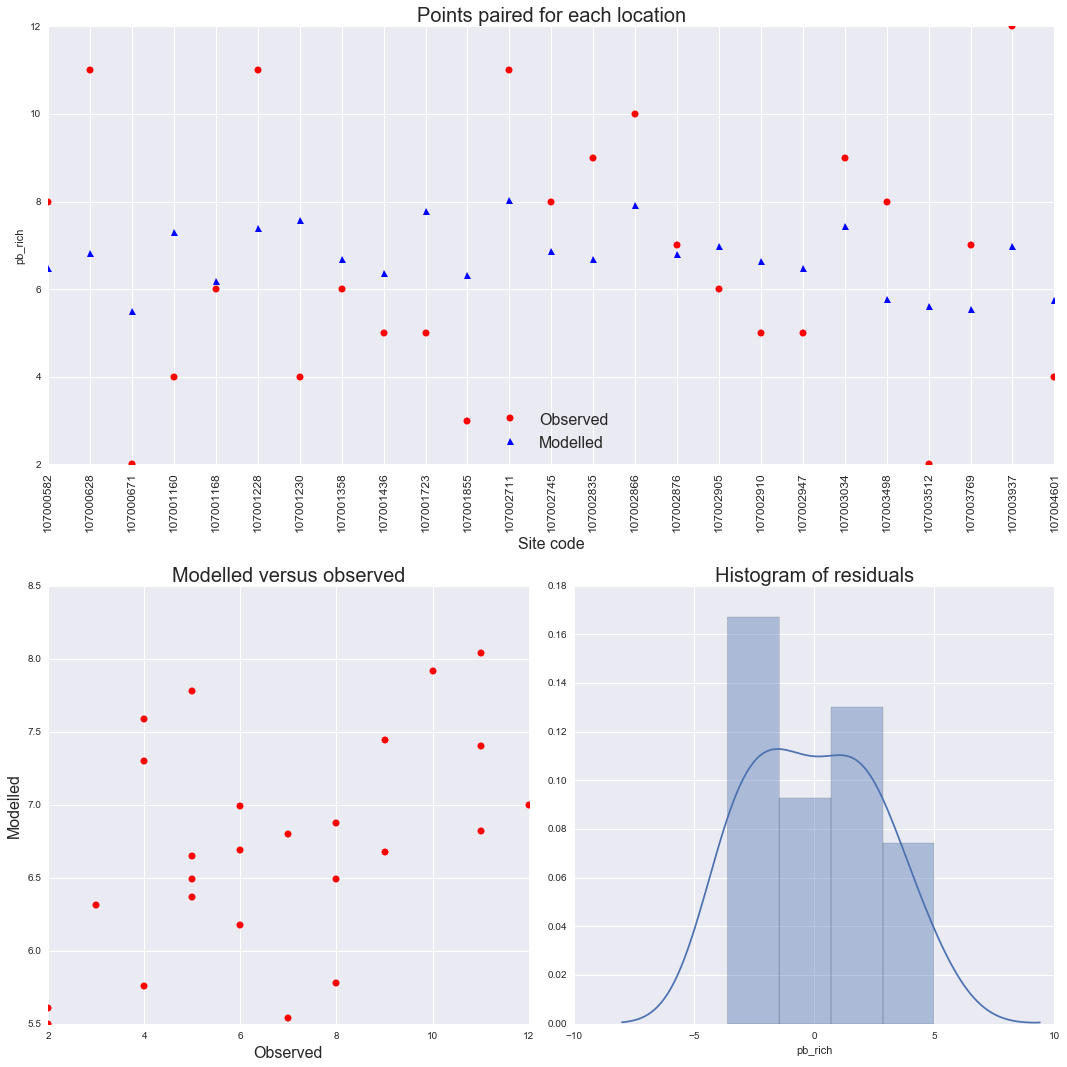

In [20]:
# Lists of explan and resp vars
exp_vars = ['lon', 'lat', 'mean', 'm01', 'm02', 'm03', 'm04', 'm05', 'm06',
            'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'min', 'p05', 'p25',
            'p50', 'p75', 'p95', 'max', 'range', 'iqr', 'range90', 'cv',
            'days_to_max', 'days_to_min', 'days_to_p05', 'days_to_p95',
            'ma_07_max', 'ma_07_min', 'ma_30_max', 'ma_30_min', 'ma_90_max',
            'ma_90_min', 'revs_per_yr', 'tn', 'tp', 'ph', 'cond', 'toc']

resp_var = 'pb_rich'

# OLS regression
res = mlr(df, exp_vars, resp_var, 
          method='el-net', fit_intercept=True, 
          kcv=3, normalize=False)
res

## 5. All sites

### 5.1. OLS chem only

Number of sites included: 65
Mean r2 from 3-fold CV: -2.995

r2 (based on the calibration data i.e. meaningless!): 0.622051472547

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)



,effect,error,signif
tn,-0.671725,2.179867,False
tp,-0.029384,0.026642,True
ph,-0.028744,3.666480,False
cond,-0.030691,0.022073,True
toc,0.625699,1.045423,False


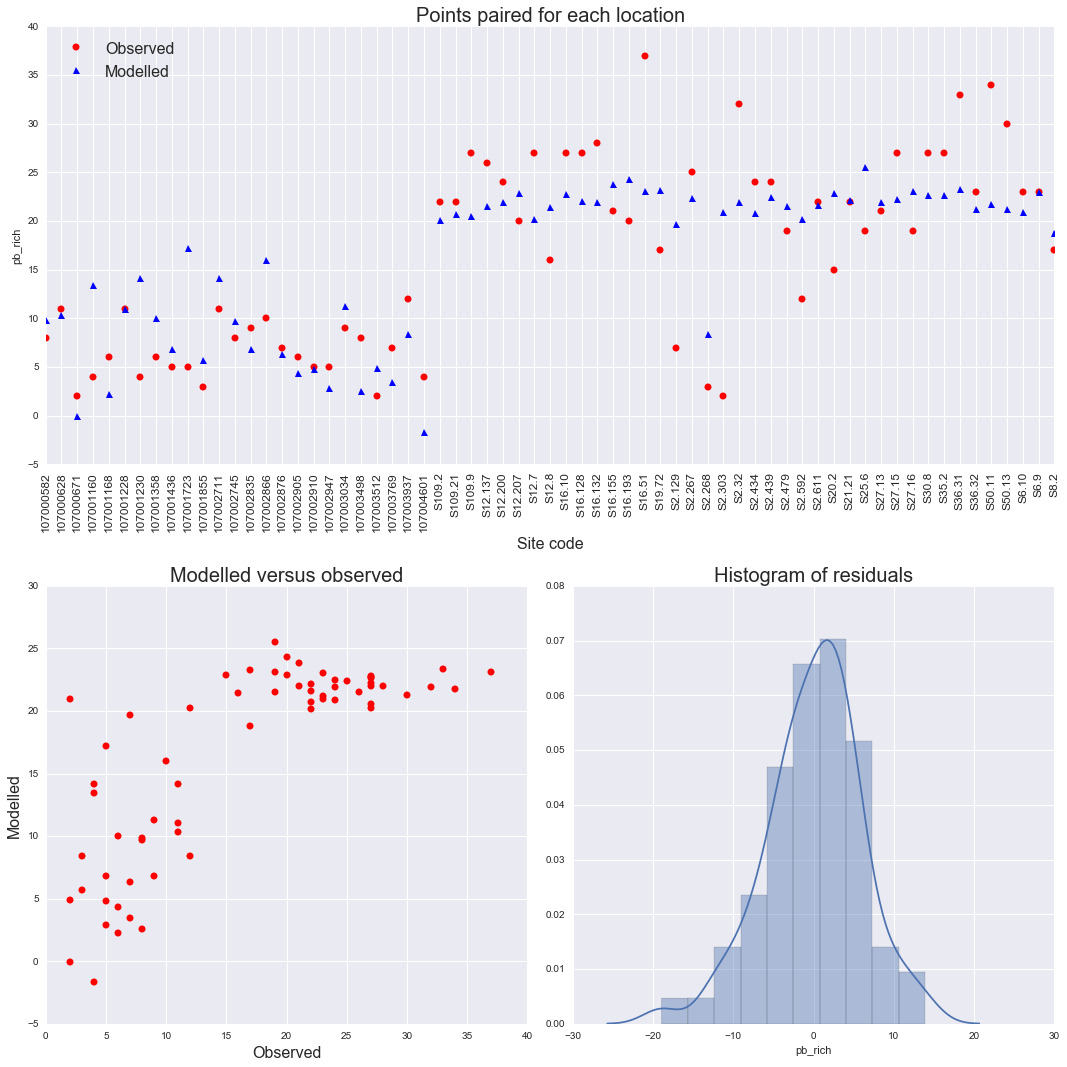

In [32]:
df = pb1_df.copy()

# Lists of explan and resp vars
exp_vars = ['tn', 'tp', 'ph', 'cond', 'toc']
resp_var = 'pb_rich'

print 'Number of sites included:', len(df)

# OLS
res = mlr(df, exp_vars, resp_var, 
          method='ols', fit_intercept=True, 
          kcv=3, normalize=False)
res

### 5.2. Elastic net all vars

Mean r2 from 3-fold CV: -11.287

r2 (based on the calibration data i.e. meaningless!): 0.0

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

Elastic net alpha: 525.320236686
Elastic net L1 ratio: 0.5



,effect,error,signif
mean,0.0,0.006151,False
m01,0.0,0.180531,False
m02,0.0,0.116719,False
m03,-0.0,0.461719,False
m04,0.0,0.292104,False
m05,0.0,0.350446,False
m06,0.0,0.274277,False
m07,0.0,0.288166,False
m08,0.0,0.286429,False
m09,0.0,0.530546,False


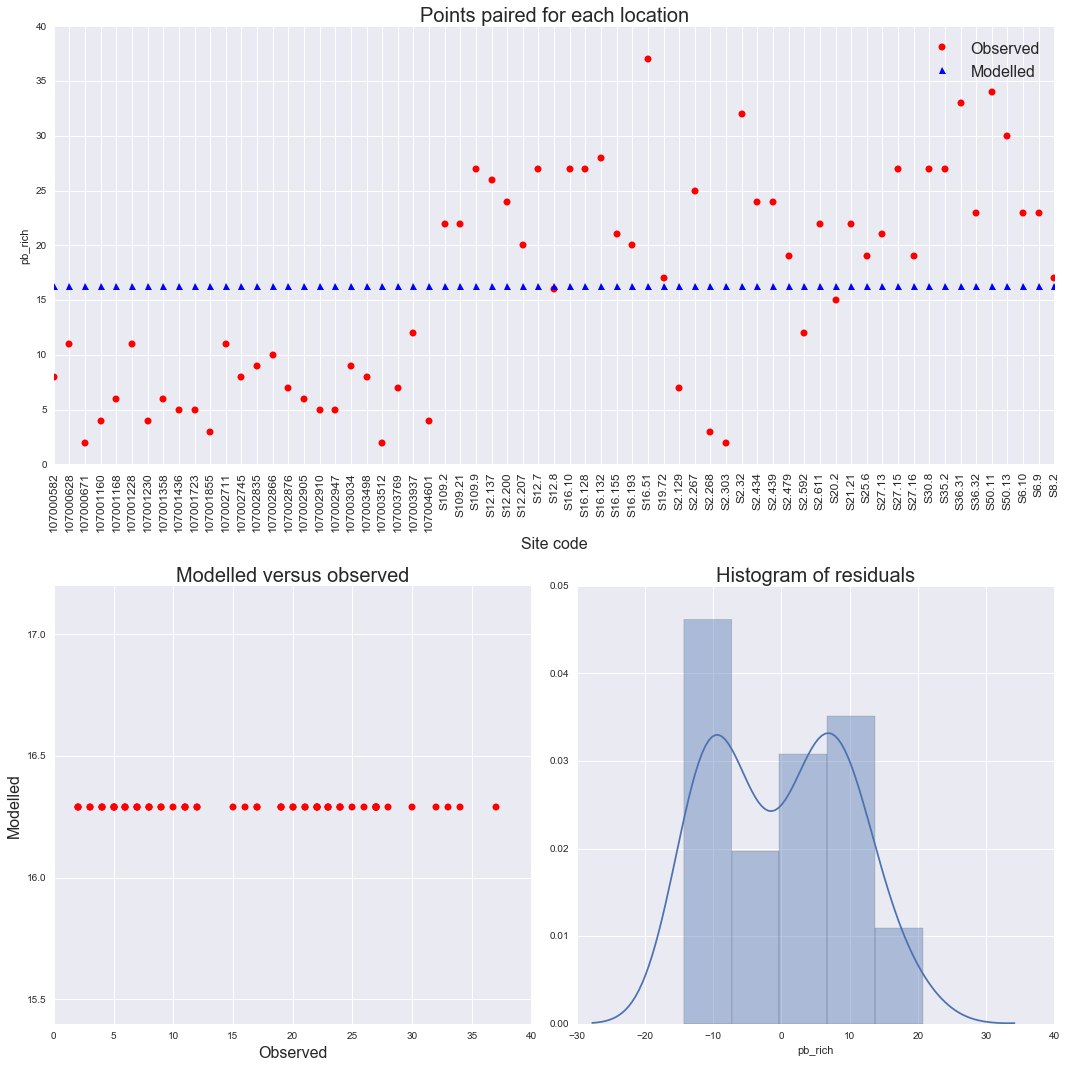

In [35]:
# Lists of explan and resp vars
exp_vars = ['lon', 'lat', 'mean', 'm01', 'm02', 'm03', 'm04', 'm05', 'm06',
            'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'min', 'p05', 'p25',
            'p50', 'p75', 'p95', 'max', 'range', 'iqr', 'range90', 'cv',
            'days_to_max', 'days_to_min', 'days_to_p05', 'days_to_p95',
            'ma_07_max', 'ma_07_min', 'ma_30_max', 'ma_30_min', 'ma_90_max',
            'ma_90_min', 'revs_per_yr', 'tn', 'tp', 'ph', 'cond', 'toc']

exp_vars = ['mean', 'm01', 'm02', 'm03', 'm04', 'm05', 'm06',
            'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'min', 'p05', 'p25',
            'p50', 'p75', 'p95', 'max', 'range', 'iqr', 'range90', 'cv',
            'days_to_max', 'days_to_min', 'days_to_p05', 'days_to_p95',
            'ma_07_max', 'ma_07_min', 'ma_30_max', 'ma_30_min', 'ma_90_max',
            'ma_90_min', 'revs_per_yr']

resp_var = 'pb_rich'

# OLS regression
res = mlr(df, exp_vars, resp_var, 
          method='el-net', fit_intercept=True, 
          kcv=3, normalize=False)
res